In [44]:
import os
import pandas as pd
import librosa
import warnings

import tsfel
from tqdm import tqdm

import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


## **Membaca Dataset**

In [6]:
# -- Mengabaikan peringatan dari librosa terkait format non-wav --
warnings.filterwarnings('ignore', category=UserWarning, module='librosa')

# Konfigurasi Path dan Label 
dataset_path = 'dataset/audio' 

In [7]:
def load_audio_dataset(dataset_path=dataset_path, valid_exts=('.aac', '.mp3')):
    """
    Membaca seluruh file audio dari dataset dengan struktur multi-label.
    Return: list berisi dictionary (filename, audio_signal, sr, label_aksi, label_identitas)
    """
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"❌ Folder '{dataset_path}' tidak ditemukan.")

    print("🚀 Memulai proses pembacaan file audio dari struktur multi-label...\n")
    data_list = []

    # Ambil semua folder label di dalam dataset/audio
    label_folders = [
        f for f in os.listdir(dataset_path)
        if os.path.isdir(os.path.join(dataset_path, f))
    ]

    # Loop tiap folder (contoh: 'buka fauzan', 'tutup fikri')
    for folder_name in label_folders:
        folder_path = os.path.join(dataset_path, folder_name)

        # Pisahkan nama folder menjadi dua label
        try:
            label_aksi, label_identitas = folder_name.strip().split(' ')
        except ValueError:
            print(f"⚠️  Format folder '{folder_name}' tidak sesuai (harus 'aksi identitas'). Dilewati.\n")
            continue

        print(f"📂 Membaca folder: {folder_name} ...")

        # Loop semua file audio di dalam folder
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(valid_exts):
                file_path = os.path.join(folder_path, filename)

                try:
                    # Membaca file audio
                    audio_signal, sr = librosa.load(file_path, sr=None)
                    data_list.append({
                        'filename': filename,
                        'audio_signal': audio_signal,
                        'sampling_rate': sr,
                        'label_aksi': label_aksi,
                        'label_identitas': label_identitas
                    })

                except Exception as e:
                    print(f"  ❌ Error membaca file '{filename}': {e}")

    print("\n✅ Proses pembacaan data selesai.")
    print(f"📊 Total file berhasil dibaca: {len(data_list)}")
    return data_list


## **Ekstraksi Fitur**

In [8]:
def extract_features_tsfel(data_list):
    """
    Mengekstraksi fitur dari setiap sinyal audio menggunakan TSFEL.
    data_list: list hasil dari load_audio_dataset()
    return: DataFrame berisi fitur + label
    """
    # 1️⃣ Ambil konfigurasi default TSFEL (fitur temporal, statistical, spectral)
    cfg = tsfel.get_features_by_domain()

    feature_dfs = []  # Menyimpan hasil ekstraksi per file

    print("🚀 Memulai proses ekstraksi fitur menggunakan TSFEL...\n")

    for i, data in enumerate(data_list, 1):
        signal = data['audio_signal']
        sr = data['sampling_rate']

        try:
            # 2️⃣ Ekstraksi fitur untuk satu sinyal
            features = tsfel.time_series_features_extractor(cfg, signal, fs=sr, verbose=0)

            # 3️⃣ Tambahkan label & metadata ke hasil fitur
            features['filename'] = data['filename']
            features['label_aksi'] = data['label_aksi']
            features['label_identitas'] = data['label_identitas']

            feature_dfs.append(features)

            print(f"✅ [{i}/{len(data_list)}] Fitur diekstrak untuk file: {data['filename']}")

        except Exception as e:
            print(f"❌ Error saat ekstraksi fitur {data['filename']}: {e}")

    # 4️⃣ Gabungkan semua hasil fitur menjadi satu DataFrame besar
    feature_df = pd.concat(feature_dfs, ignore_index=True)

    print("\n🎉 Ekstraksi fitur selesai!")
    print(f"📊 Total data fitur: {feature_df.shape[0]} baris, {feature_df.shape[1]} kolom")

    return feature_df


In [9]:
if __name__ == "__main__":
    # Jalankan kode membaca dataset
    dataset = load_audio_dataset()
    features_df = extract_features_tsfel(dataset)

🚀 Memulai proses pembacaan file audio dari struktur multi-label...

📂 Membaca folder: buka fauzan ...


C:\Users\MyBook Z Series\AppData\Local\Temp\ipykernel_13992\2150380174.py:38: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_signal, sr = librosa.load(file_path, sr=None)
d:\Perkuliahan\Semester 5\Poyek Sains Data\PSD\venv_py\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
C:\Users\MyBook Z Series\AppData\Local\Temp\ipykernel_13992\2150380174.py:38: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_signal, sr = librosa.load(file_path, sr=None)
d:\Perkuliahan\Semester 5\Poyek Sains Data\PSD\venv_py\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


📂 Membaca folder: buka fikri ...
📂 Membaca folder: tutup fauzan ...
📂 Membaca folder: tutup fikri ...

✅ Proses pembacaan data selesai.
📊 Total file berhasil dibaca: 400
🚀 Memulai proses ekstraksi fitur menggunakan TSFEL...

✅ [1/400] Fitur diekstrak untuk file: 20251030_183541.aac
✅ [2/400] Fitur diekstrak untuk file: 20251030_183623.aac
✅ [3/400] Fitur diekstrak untuk file: 20251030_183635.aac
✅ [4/400] Fitur diekstrak untuk file: 20251030_183717.aac
✅ [5/400] Fitur diekstrak untuk file: 20251030_183723.aac
✅ [6/400] Fitur diekstrak untuk file: 20251030_183736.aac
✅ [7/400] Fitur diekstrak untuk file: 20251030_183740.aac
✅ [8/400] Fitur diekstrak untuk file: 20251030_183748.aac
✅ [9/400] Fitur diekstrak untuk file: 20251030_183754.aac
✅ [10/400] Fitur diekstrak untuk file: 20251030_183813.aac
✅ [11/400] Fitur diekstrak untuk file: 20251030_183817.aac
✅ [12/400] Fitur diekstrak untuk file: 20251030_183835.aac
✅ [13/400] Fitur diekstrak untuk file: 20251030_183938.aac
✅ [14/400] Fitur 

## **Feature Selection using Information Gain**

In [20]:
def feature_selection_information_gain(features_df):
    # 1️⃣ Pisahkan fitur dan label
    X = features_df.drop(columns=["label_aksi", "label_identitas"], errors="ignore")
    y_aksi = features_df["label_aksi"]
    y_identitas = features_df["label_identitas"]

    # 2️⃣ Ambil hanya kolom numerik (hindari string seperti nama file)
    X = X.select_dtypes(include=[np.number])

    # 3️⃣ Tangani missing value (NaN)
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)

    # 4️⃣ Encode label menjadi angka
    le_aksi = LabelEncoder()
    le_identitas = LabelEncoder()
    y_aksi_encoded = le_aksi.fit_transform(y_aksi)
    y_identitas_encoded = le_identitas.fit_transform(y_identitas)

    # 5️⃣ Hitung Information Gain (Mutual Information)
    ig_aksi = mutual_info_classif(X_imputed, y_aksi_encoded, discrete_features='auto')
    ig_identitas = mutual_info_classif(X_imputed, y_identitas_encoded, discrete_features='auto')

    # 6️⃣ Gabungkan hasil ke DataFrame
    ig_df = pd.DataFrame({
        "Feature": X.columns,
        "IG_Aksi": ig_aksi,
        "IG_Identitas": ig_identitas
    }).sort_values(by="IG_Aksi", ascending=False)

    # 7️⃣ Visualisasi skor
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(ig_df)), ig_df["IG_Aksi"])
    plt.xticks(range(len(ig_df)), ig_df["Feature"], rotation=90)
    plt.title("Information Gain terhadap Label Aksi")
    plt.xlabel("Fitur")
    plt.ylabel("Skor IG")
    plt.tight_layout()
    plt.show()

    return ig_df


### *Show Score Information Gain*

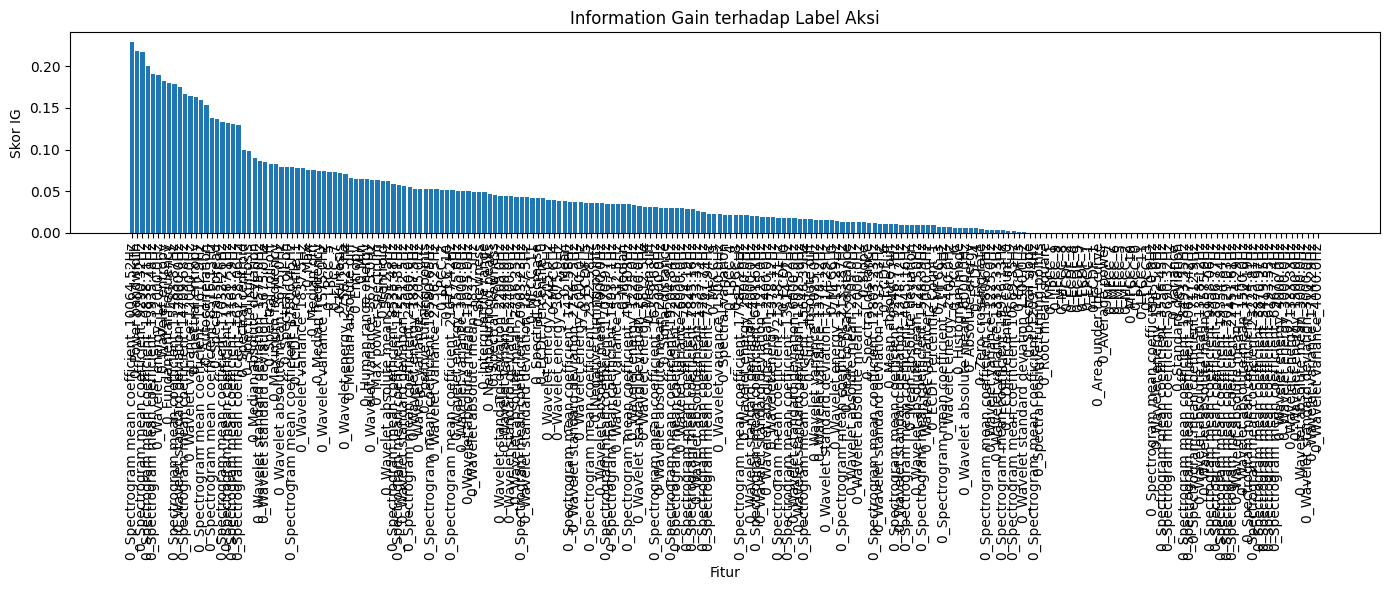


🔝 10 fitur dengan Information Gain tertinggi terhadap label_aksi:
                                       Feature   IG_Aksi  IG_Identitas
156  0_Spectrogram mean coefficient_10064.52Hz  0.229275      0.661489
66                           0_Power bandwidth  0.218374      0.229815
186   0_Spectrogram mean coefficient_9290.32Hz  0.217301      0.683429
157  0_Spectrogram mean coefficient_10838.71Hz  0.199748      0.650519
161  0_Spectrogram mean coefficient_13935.48Hz  0.190200      0.672459
196                 0_Wavelet energy_12000.0Hz  0.188961      0.661489
136                          0_Wavelet entropy  0.181960      0.174322
20                     0_Fundamental frequency  0.179550      0.478973
164  0_Spectrogram mean coefficient_15483.87Hz  0.178603      0.650519
205     0_Wavelet standard deviation_12000.0Hz  0.175366      0.661489


In [22]:
if __name__ == "__main__":
    ig_results = feature_selection_information_gain(features_df)
    print("\n🔝 10 fitur dengan Information Gain tertinggi terhadap label_aksi:")
    print(ig_results.head(10))

In [56]:
def feature_selection_information_gain(features_df):

    # 1️⃣ Pisahkan fitur dan label
    X = features_df.drop(columns=["label_aksi", "label_identitas"])
    y_aksi = features_df["label_aksi"]

    # 2️⃣ Pilih hanya kolom numerik
    X_numeric = X.select_dtypes(include=[np.number])

    # 3️⃣ Tangani missing value
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X_numeric)

    # 4️⃣ Encode label
    le_aksi = LabelEncoder()
    y_aksi_encoded = le_aksi.fit_transform(y_aksi)

    # 5️⃣ Hitung information gain
    ig_scores = mutual_info_classif(X_imputed, y_aksi_encoded, discrete_features='auto', random_state=42)

    ig_df = pd.DataFrame({
        "Feature": X_numeric.columns,
        "IG_Score": ig_scores
    }).sort_values(by="IG_Score", ascending=False).reset_index(drop=True)

    # ✅ Gunakan hanya kolom numerik, bukan X.columns
    X_imputed_df = pd.DataFrame(X_imputed, columns=X_numeric.columns)

    return ig_df, X_imputed_df, y_aksi_encoded


In [57]:
def evaluate_feature_reduction(ig_df, X, y, step=1):
    # 1️⃣ Buang fitur dengan IG = 0
    ig_df = ig_df[ig_df["IG_Score"] > 0].reset_index(drop=True)

    print(f"Total fitur aktif setelah filter IG>0: {len(ig_df)}")

    results = []

    # 2️⃣ Looping dari semua fitur hingga 1 fitur (step 5)
    for n_features in range(len(ig_df), 0, -step):
        top_features = ig_df["Feature"].iloc[:n_features].tolist()

        # Ambil subset X
        X_subset = pd.DataFrame(X, columns=ig_df["Feature"])[top_features]

        # Split data (train/test)
        X_train, X_test, y_train, y_test = train_test_split(
            X_subset, y, test_size=0.2, random_state=42
        )

        # Model KNN
        model = KNeighborsClassifier(n_neighbors=5)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)

        results.append({
            "Jumlah_Fitur": n_features,
            "Akurasi": acc
        })

        print(f"Fitur: {n_features:3d} | Akurasi: {acc:.4f}")

    # 3️⃣ Simpan hasil ke DataFrame
    results_df = pd.DataFrame(results)
    return results_df


### *Show Score Valuation with Reduce Feature*

Total fitur aktif setelah filter IG>0: 172
Fitur: 172 | Akurasi: 0.4125
Fitur: 171 | Akurasi: 0.4125
Fitur: 170 | Akurasi: 0.4125
Fitur: 169 | Akurasi: 0.4125
Fitur: 168 | Akurasi: 0.4125
Fitur: 167 | Akurasi: 0.4125
Fitur: 166 | Akurasi: 0.4125
Fitur: 165 | Akurasi: 0.4125
Fitur: 164 | Akurasi: 0.4125
Fitur: 163 | Akurasi: 0.4125
Fitur: 162 | Akurasi: 0.4125
Fitur: 161 | Akurasi: 0.4125
Fitur: 160 | Akurasi: 0.4125
Fitur: 159 | Akurasi: 0.4125
Fitur: 158 | Akurasi: 0.4125
Fitur: 157 | Akurasi: 0.4125
Fitur: 156 | Akurasi: 0.4125
Fitur: 155 | Akurasi: 0.4125
Fitur: 154 | Akurasi: 0.4125
Fitur: 153 | Akurasi: 0.4125
Fitur: 152 | Akurasi: 0.4125
Fitur: 151 | Akurasi: 0.4125
Fitur: 150 | Akurasi: 0.4125
Fitur: 149 | Akurasi: 0.4125
Fitur: 148 | Akurasi: 0.4125
Fitur: 147 | Akurasi: 0.4125
Fitur: 146 | Akurasi: 0.4125
Fitur: 145 | Akurasi: 0.4125
Fitur: 144 | Akurasi: 0.4125
Fitur: 143 | Akurasi: 0.4125
Fitur: 142 | Akurasi: 0.4125
Fitur: 141 | Akurasi: 0.6625
Fitur: 140 | Akurasi: 0.6625


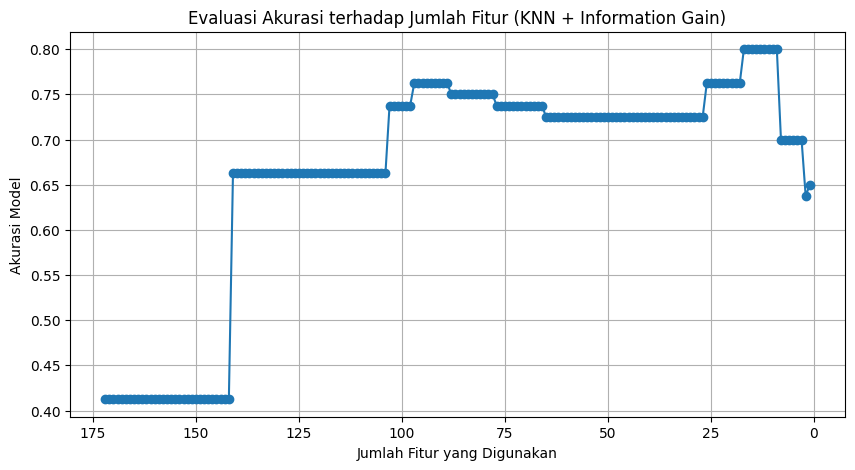


🎯 Jumlah fitur optimal: 17.0
📊 Akurasi tertinggi: 0.8000


In [61]:
if __name__ == "__main__":
    # Asumsikan features_df sudah kamu punya dari tahap TSFEL
    ig_df, X_imputed, y_aksi_encoded = feature_selection_information_gain(features_df)

    # Evaluasi performa dengan pengurangan step 5
    results_df = evaluate_feature_reduction(ig_df, X_imputed, y_aksi_encoded, step=1)

    # ============================================================
    # 📈 Visualisasi hasil
    # ============================================================
    plt.figure(figsize=(10, 5))
    plt.plot(results_df["Jumlah_Fitur"], results_df["Akurasi"], marker='o', linestyle='-')
    plt.title("Evaluasi Akurasi terhadap Jumlah Fitur (KNN + Information Gain)")
    plt.xlabel("Jumlah Fitur yang Digunakan")
    plt.ylabel("Akurasi Model")
    plt.gca().invert_xaxis()  # dari banyak ke sedikit fitur
    plt.grid(True)
    plt.show()

    # Menampilkan fitur optimal
    best_row = results_df.loc[results_df["Akurasi"].idxmax()]
    print(f"\n🎯 Jumlah fitur optimal: {best_row['Jumlah_Fitur']}")
    print(f"📊 Akurasi tertinggi: {best_row['Akurasi']:.4f}")